In [2]:
!pip install torch transformer-lens datasets -qqq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 12.3

In [2]:
# HuggingFace Authentication
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)
print("✓ Successfully authenticated with Hugging Face")

✓ Successfully authenticated with Hugging Face


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings
import gc

torch.set_grad_enabled(False) # Disable gradient tracking as we are not training

2025-10-10 20:20:28.755721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760127629.008747     417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760127629.085028     417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

In [4]:
model = HookedTransformer.from_pretrained('gemma-2-2b-it', center_writing_weights=False, device='cuda', dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [5]:
# Helper Functions

def extract_activations(model, prompt, max_new_tokens=20, temperature=0):
    """
    Runs the model on the input text, caches activations, and returns results.

    Parameters
    ----------
    model : HookedTransformer
        The transformer model to run.
    prompt : str
        Input text prompt.
    max_new_tokens : int, optional
        Maximum number of tokens to generate.
    temperature : float, optional
        Temperature of the model. Set to 0 (greedy decoding) by default.

    Returns
    -------
    dict
        Dictionary containing:
        - 'activations': cached intermediate values.
        - 'final_logits': output logits.
        - 'str_tokens': list of token strings.
    """

    # Generate model response tokens
    tokens = model.generate(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        prepend_bos=False,
        return_type='tokens'
    )

    # Run model and record activations cache
    final_logits, cache = model.run_with_cache(tokens, prepend_bos=False)
    cache = cache.remove_batch_dim()
    cache_data = {
        'activations': cache,
        'final_logits': final_logits,
        'str_tokens': model.to_str_tokens(tokens[0])
    }

    return cache_data

def logit_lens(model, activations, norm=False, p=2):
    """
    Projects hidden activations to vocabulary logits using final LayerNorm and unembedding.

    Parameters
    ----------
    model : HookedTransformer
        The model providing projection layers.
    activations : torch.Tensor
        Tensor of shape [..., d_model] representing intermediate activations.
    norm : bool
        Whether to normalize the unembedding matrix or not (for NormedLens)
    p : float
        The parameter for normalizing the unembedding matrix using p-norm.
        Considered only if `norm=True`

    Returns
    -------
    torch.Tensor
        Logits over vocabulary, shape [..., vocab_size].
    """
    # Move activations to the model's device if needed
    if activations.device != model.cfg.device:
        activations = activations.to(model.cfg.device)

    # Apply layer normalization and unembedding
    normalized = model.ln_final(activations)
    if norm:
        logits = normalized @ F.normalize(model.W_U, p=p, dim=0)
    else:
        logits = model.unembed(normalized)

    return logits

def plot_top_k(model, cache_data, hook_name, token_pos, k=10, norm=False, p=2):
    """
    Visualizes top-k predicted tokens and their probabilities for a given layer/hook and token position.

    Parameters
    ----------
    model : HookedTransformer
        The transformer model.
    cache_data : dict
        Cached activations and string tokens.
    hook_name : str
        Activation hook name to use.
    token_pos : int
        Token position in the sequence.
    k : int, optional
        Number of top predictions to show.
    norm : bool
        Whether to normalize the unembedding matrix or not (for NormedLens)
    p : float
        The parameter for normalizing the unembedding matrix using p-norm.
        Considered only if `norm=True`
    """
    # Retrieve activations for the specified hook and token position
    activations = cache_data['activations'][hook_name][token_pos]
    logits = logit_lens(model, activations, norm, p)

    # Get top-k logits and their indices
    top_logits, top_indices = torch.topk(logits, k=k)
    probs = F.softmax(logits, dim=-1)[top_indices].tolist()
    tokens = [model.to_string(idx.item()) for idx in top_indices]

    # Create Plotly bar chart
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=list(range(len(tokens))),
        y=probs,
        text=[f"'{token}'" for token in tokens],
        textposition='outside',
        hovertemplate='<b>Token:</b> %{text}<br><b>Probability:</b> %{y:.4f}<extra></extra>',
        marker=dict(
            color=probs,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Probability")
        )
    ))
    fig.update_layout(
        title=f'Top-{k} Predictions at Position {token_pos}<br>'
              f'Layer {hook_name.split(".")[1]}, Hook: {hook_name}<br>'
              f'Current Token: \"{cache_data["str_tokens"][token_pos]}\"',
        xaxis_title='Rank',
        yaxis_title='Probability',
        xaxis=dict(tickmode='array', tickvals=list(range(len(tokens))),
                  ticktext=[f'{i+1}' for i in range(len(tokens))]),
        height=500,
        showlegend=False
    )
    fig.show()

    # Print summary
    print(f"\nHook: {hook_name}")
    print(f"Token Position: {token_pos}")
    print(f"Current Token: '{cache_data['str_tokens'][token_pos]}'")
    print(f"Top prediction: '{tokens[0]}' (prob: {probs[0]:.4f})")

def plot_logit_lens_heatmap(model, cache_data, start, end, hook_filter, layers=None, norm=False, p=2, figsize=(35, 12)):
    """
    Plots a heatmap of top logit lens predictions across layers and token positions.

    Parameters
    ----------
    model : HookedTransformer
        The model used for projecting logits.
    cache_data : dict
        Cached activations and tokens.
    start : int
        Starting token index.
    end : int
        Ending token index.
    hook_filter : str or list of str
        Filters for selecting relevant layer hooks. Should be a substring or a list of
        substrings that will be matched against activation hook names on which logit
        lens can be done. For example, 'attn' will pick the layers of the form
        `blocks.{layer}.hook_attn_out`, 'resid_post' will pick the layers of the form
        `blocks.{layer}.hook_resid_post`, ['attn', 'mlp'] will pick the layers of both
        the forms `blocks.{layer}.hook_attn_out` and `blocks.{layer}.hook_mlp_out`
    layers : list
        List of layers to plot. Defaults to all.
    norm : bool
        Whether to normalize the unembedding matrix or not (for NormedLens)
    p : float
        The parameter for normalizing the unembedding matrix using p-norm.
        Considered only if `norm=True`
    figsize : tuple of int, optional
        Size of the plot.

    Returns
    -------
    matplotlib.figure.Figure
        Figure showing top token predictions and their confidences.
    """

    # Normalize hook_filter to a list
    if isinstance(hook_filter, str):
        hook_filter = [hook_filter]

    # Retrieve token data and activations
    str_tokens = cache_data['str_tokens']
    seq_len = len(str_tokens)
    activations_data = cache_data['activations']

    # Identify relevant hooks
    if not layers:
        layers = list(range(model.cfg.n_layers))
    hooks = []
    for key in sorted(
        activations_data.keys(),
        key=lambda x: int(x.split('.')[1]) if 'blocks.' in x else float('inf')
    ):
        if (
            key.startswith('blocks.')
            and ('resid' in key or 'normalized' in key or 'out' in key)
            and any(f in key for f in hook_filter)
            and int(key.split('.')[1]) in layers
        ):
            hooks.append(key)

    if not hooks:
        raise ValueError('No hooks under the given filter!')

    # Collect top predictions and probabilities
    all_preds = []
    all_probs = []

    for hook in hooks:
        activations = activations_data[hook]  # shape: [seq_len, d_model]
        logits = logit_lens(model, activations, norm, p)  # shape: [seq_len, vocab_size]

        probs = F.softmax(logits, dim=-1)  # shape: [seq_len, vocab_size]
        if norm:
            probs = torch.log(probs)
        top_probs, top_indices = torch.max(probs, dim=-1)  # shape: [seq_len]

        top_tokens = model.to_str_tokens(top_indices, prepend_bos=False)
        for i in range(len(top_tokens)):
            if len(top_tokens[i]) > 10:
                top_tokens[i] = top_tokens[i][:8] + '...'

        all_preds.append(top_tokens)
        all_probs.append(top_probs.detach().cpu().numpy())

    # Slice to target token range
    pred_matrix = np.array(all_preds, dtype=object)[:, start:end]
    prob_matrix = np.array(all_probs)[:, start:end]

    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        prob_matrix,
        annot=pred_matrix,
        fmt='',
        cmap='viridis',
        cbar_kws={'label': f'Prediction {"Log-p" if norm else "P"}robability'},
        xticklabels=[f'Pos {i}' for i in range(start, end)],
        yticklabels=[f"Layer {' '.join(hook.split('.')[1:])}" for hook in hooks],
        ax=ax
    )

    # Add actual tokens above the plot
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(np.arange(len(str_tokens[start:end])) + 0.5)
    ax2.set_xticklabels(str_tokens[start:end], rotation=45, ha='left')
    ax2.set_xlabel('Actual Tokens')

    # Set labels and title
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Layer')
    ax.set_title(f'{"Normed" if norm else "Logit"} Lens: Top Predictions Across Layers')

    # Avoid font warnings
    warnings.filterwarnings("ignore", message="Glyph.*missing from current font")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()

    return fig


# Unembedding Vectors and the Residual Stream

In [13]:
for prompt in ['The furry animal that chases mice and meows is',
               'The season that comes after winter and before monsoon is']:
    # Select tokens
    np.random.seed(8) # For reproducibility
    tokens =[' cat', ' dogs', ' Paris', ' milk', ' login', ' laboratory', ' shine',
             ' coat', ' summer', ' autumn', ' cats', ' city', ' lion', ' feline']
    token_ids = model.to_tokens(tokens, prepend_bos=False).cpu().numpy().flatten()
    
    # Extract unembedding vectors
    W_U = model.unembed.W_U.detach().cpu().numpy()  # shape: [d_vocab, d_model]
    vectors = np.array([W_U.T[tok_id] for tok_id in token_ids])
    
    # Use PCA to project unembedding vectors to 2D for visualization
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    # Define a synthetic residual stream in d_model space
    logits, cache = model.run_with_cache(prompt, prepend_bos=False)
    residual_stream = cache['ln_final.hook_normalized'][0,-1,:].detach().cpu().numpy()
    #residual_stream = vectors[0] + np.random.normal(0, 1, vectors[0].shape)
    residual_2d = pca.transform([residual_stream])[0]
    
    # Calculate dot products (in original space)
    dot_products = vectors @ residual_stream
    
    # Plot with Plotly
    fig = go.Figure()
    
    # Residual stream arrow
    fig.add_trace(go.Scatter(
        x=[0, residual_2d[0]],
        y=[0, residual_2d[1]],
        mode='lines+markers',
        marker=dict(color='red', size=1),
        line=dict(color='red', width=3),
        name='Residual Stream'
    ))
    
    # Arrow for the residual stream
    arrow_scale = 1.0
    fig.add_annotation(
        x=residual_2d[0] * arrow_scale,
        y=residual_2d[1] * arrow_scale,
        ax=0, ay=0,
        xref='x', yref='y',
        axref='x', ayref='y',
        showarrow=True,
        arrowhead=3,
        arrowsize=1.5,
        arrowwidth=3,
        arrowcolor='red',
    )
    
    # Token points
    fig.add_trace(go.Scatter(
        x=vectors_2d[:, 0],
        y=vectors_2d[:, 1],
        mode='markers+text',
        marker=dict(size=12, color='blue'),
        text=[f"{tok}<br>Logit: {dp:.2f}" for tok, dp in zip(tokens, dot_products)],
        textposition="top center",
    ))
    
    fig.update_layout(
        title=f"Input: {prompt}",
        xaxis_title="PCA Component 1",
        yaxis_title="PCA Component 2",
        showlegend=False,
        height=700,
        width=700
    )
    
    fig.show()

# Logit Lens

In [6]:
def format_prompt(question: str) -> str:
    return f"<start_of_turn>user\n{question}<end_of_turn><start_of_turn>model\n"

  0%|          | 0/20 [00:00<?, ?it/s]

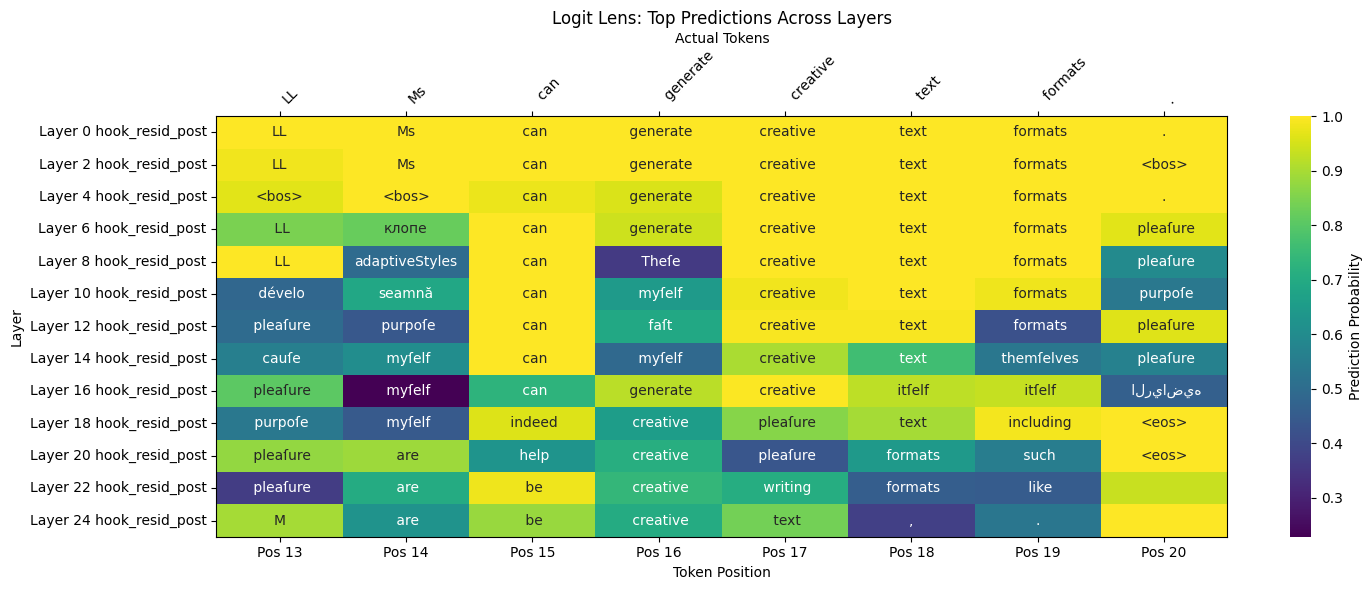

In [149]:
question = 'Write a sentence on LLM'
prompt = format_prompt(question)
cache = extract_activations(model, prompt, max_new_tokens=20)
plot_logit_lens_heatmap(model, cache, 13, 21, 'resid_post', [i for i in range(0,26,2)], figsize=(15,6))
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Matplotlib currently does not support Bengali natively.



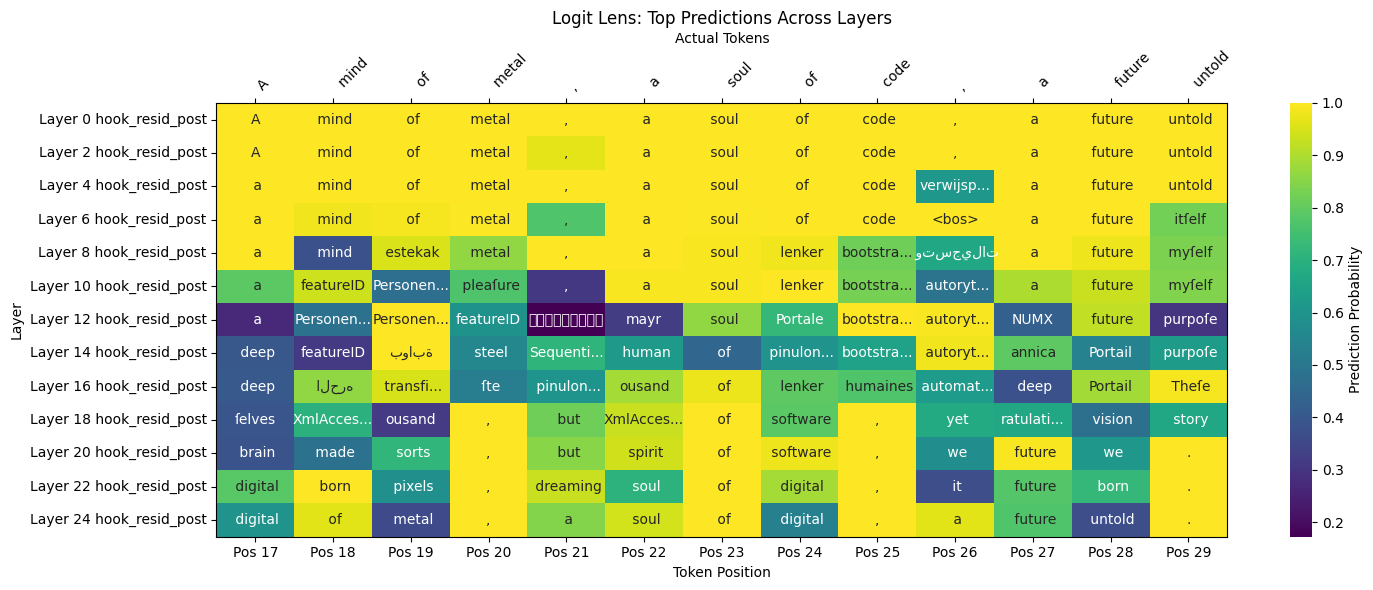

In [187]:
question = 'Write a 1-line poem on AI.'
prompt = format_prompt(question)
cache = extract_activations(model, prompt, max_new_tokens=20)
plot_logit_lens_heatmap(model, cache, 17, 30, 'resid_post', [i for i in range(0,26,2)], figsize=(15,6))
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

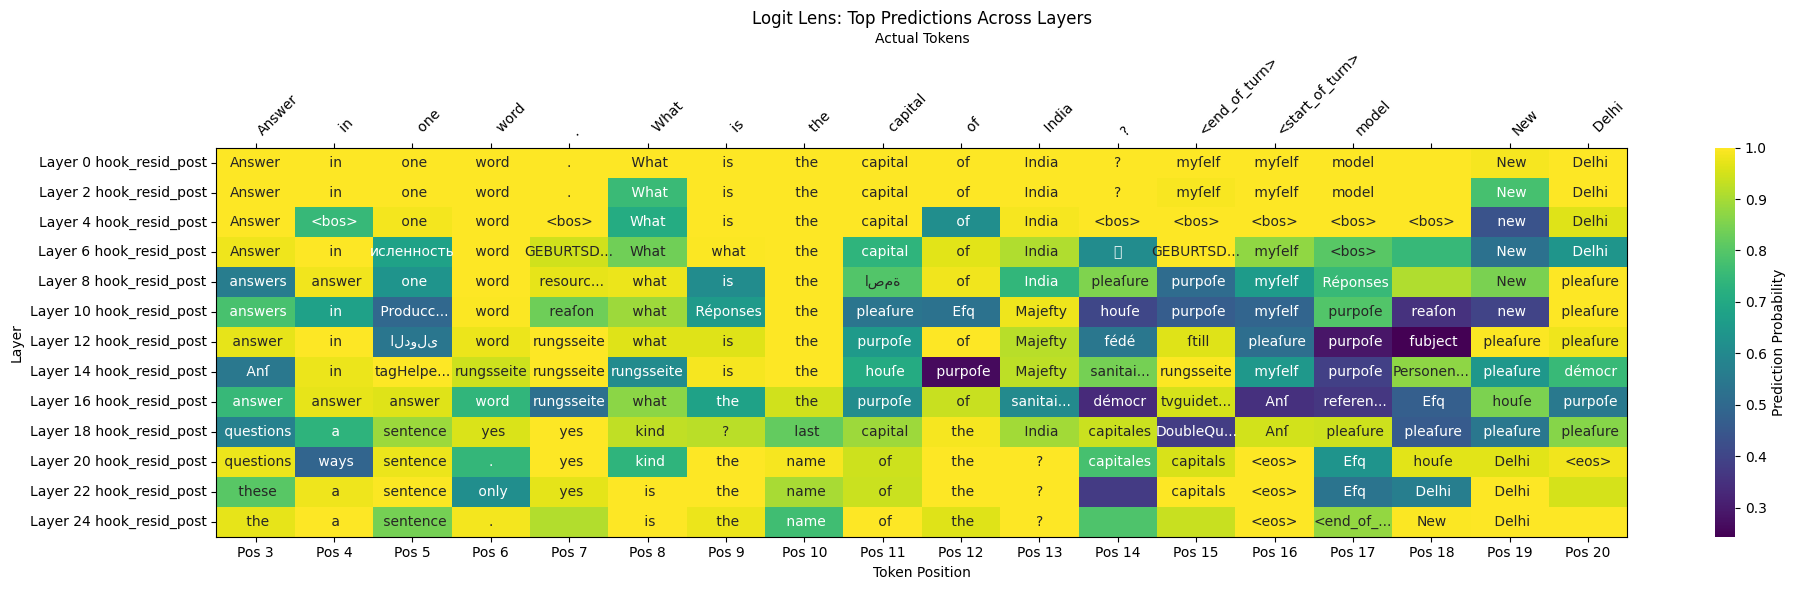

In [194]:
question = 'Answer in one word. What is the capital of India?'
prompt = format_prompt(question)
cache = extract_activations(model, prompt, max_new_tokens=20)
plot_logit_lens_heatmap(model, cache, 3, 21, 'resid_post', [i for i in range(0,26,2)], figsize=(20,6))
plt.show()

# Normed Lens

In [147]:
# Checking tokens with highest unembedding norms
norms, idx = torch.sort(model.W_U.T.norm(dim=-1), descending=True)
tokens = model.to_str_tokens(idx[:15])
for i in range(len(tokens)):
    if tokens[i].startswith(' '):
        tokens[i] = '_' + tokens[i][1:]

print('Tokens with highest unembedding norms (Gemma-2-2B-IT)\n')
for i, (tok, norm) in enumerate(zip(tokens, norms)):
    print(f'{i+1:>2})  {tok:<20}: {norm:.3f}')

Tokens with highest unembedding norms (Gemma-2-2B-IT)

 1)  _myſelf             : 16.266
 2)  _itſelf             : 15.844
 3)  _Efq                : 15.711
 4)  _CreateTagHelper    : 15.039
 5)  _Monfieur           : 15.016
 6)  tagHelperRunner     : 14.938
 7)  GEBURTSDATUM        : 14.820
 8)  AndEndTag           : 14.781
 9)  _autorytatywna      : 14.664
10)  RenderAtEndOf       : 14.594
11)  _pleaſure           : 14.570
12)  Personendaten       : 14.562
13)  +#+#                : 14.555
14)  expandindo          : 14.555
15)  MigrationBuilder    : 14.547


  0%|          | 0/20 [00:00<?, ?it/s]

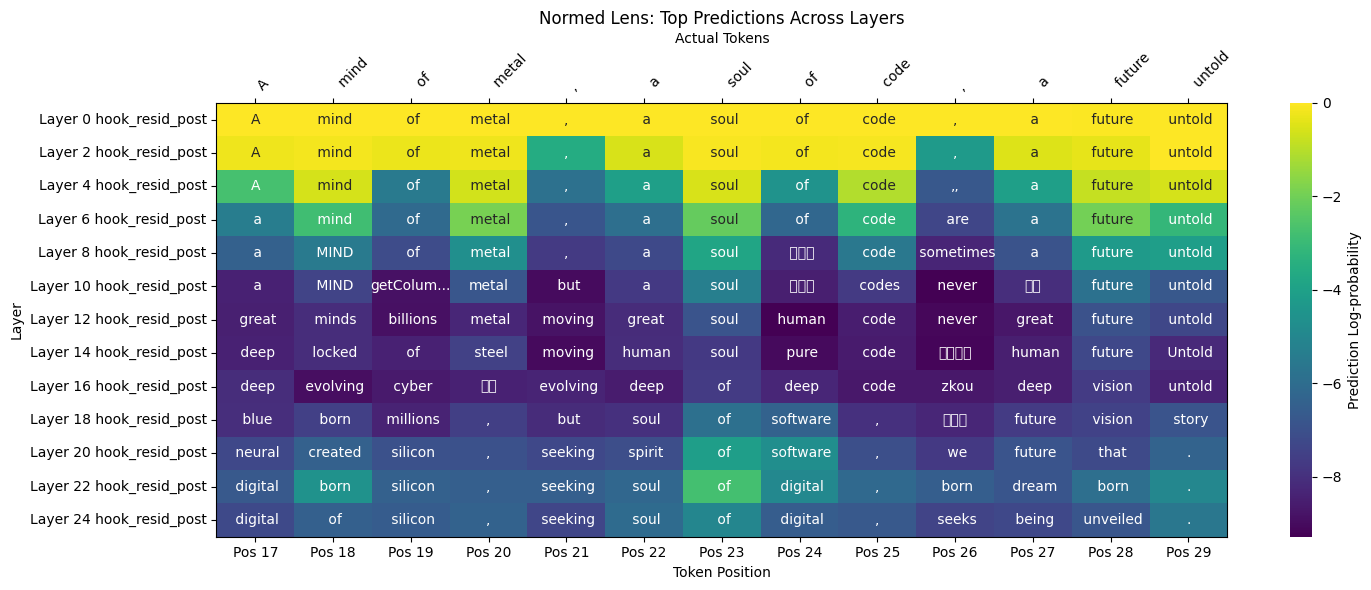

In [188]:
question = 'Write a 1-line poem on AI.'
prompt = format_prompt(question)
cache = extract_activations(model, prompt, max_new_tokens=20)
plot_logit_lens_heatmap(model, cache, 17, 30, 'resid_post', [i for i in range(0,26,2)], figsize=(15,6),norm=True)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

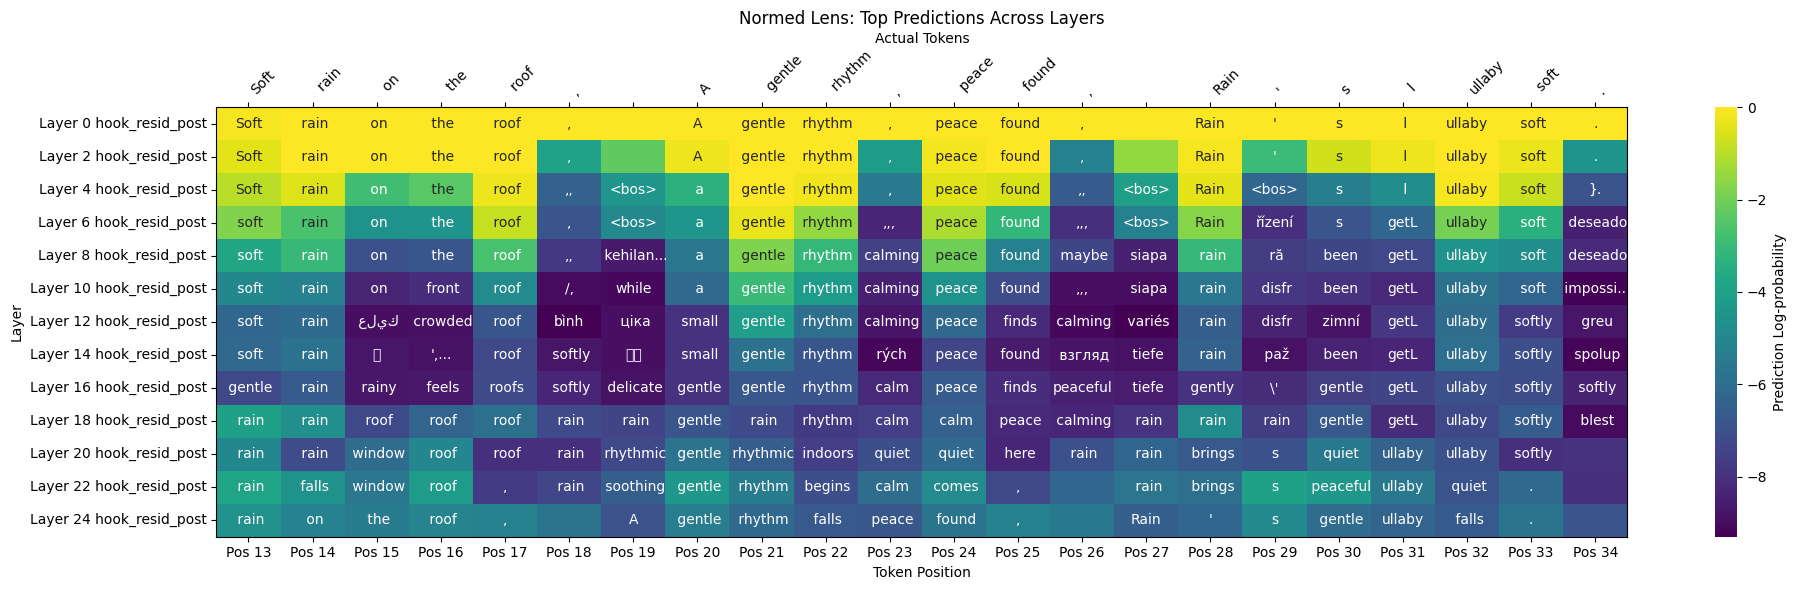

In [34]:
question = 'Write a haiku on rain.'
prompt = format_prompt(question)
cache = extract_activations(model, prompt, max_new_tokens=30)
plot_logit_lens_heatmap(model, cache, 13, 35, 'resid_post', [i for i in range(0,26,2)], norm=2, figsize=(20,6))
plt.show()

# Normed Lens Text Generation

In [13]:
def format_prompt(question: str) -> str:
    return f"<start_of_turn>user\nQ: {question}<end_of_turn><start_of_turn>model\n"

def pretty_print(text):
    print(text.replace('user\n', 'User: ').replace('model\n', '\nModel: '))

In [12]:
question = 'Who is the father of Harry Potter?'

# Normal generation
print('Normal Generation')
pretty_print(model.generate(format_prompt(question), prepend_bos=False, do_sample=False, max_new_tokens=100))

# Normed Lens generation
orig_W_U = model.unembed.W_U.clone()
W = model.unembed.W_U.T
W = W / W.norm(dim=1, keepdim=True)
model.unembed.W_U[:] = W.T
print('Normed Lens Generation')
pretty_print(model.generate(format_prompt(question), prepend_bos=False, do_sample=False, max_new_tokens=100))

# Restoring the unembedding matrix
model.unembed.W_U[:] = orig_W_U

Normal Generation


  0%|          | 0/100 [00:00<?, ?it/s]

User: Q: Who is the father of Harry Potter?
Model: This is a bit of a trick question!  Harry Potter's father is **James Potter**. 

Normed Lens Generation


  0%|          | 0/100 [00:00<?, ?it/s]

User: Q: Who is the father of Harry Potter?
Model: This is tricky because Harry Potter doesn't have a father in the traditional sense! Here's why:

* **Harry's parents were Lily and James Potter.** They were killed by Lord Voldemort when Harry was very young.
* **Harry was raised by his aunt and uncle, the Dursleys.** They didn't treat him well and didn't provide him with love or support.


Let me know if you have any other questions about Harry Potter! 😊✨



In [25]:
question = 'What is five plus five plus three plus two?'

# Normal generation
print('Normal Generation')
pretty_print(model.generate(format_prompt(question), prepend_bos=False, do_sample=False, max_new_tokens=60))

# Normed Lens generation
orig_W_U = model.unembed.W_U.clone()
W = model.unembed.W_U.T
W = W / W.norm(dim=1, keepdim=True)
model.unembed.W_U[:] = W.T
print('Normed Lens Generation')
pretty_print(model.generate(format_prompt(question), prepend_bos=False, do_sample=False, max_new_tokens=60))

# Restoring the unembedding matrix
model.unembed.W_U[:] = orig_W_U

Normal Generation


  0%|          | 0/60 [00:00<?, ?it/s]

User: Q: What is five plus five plus three plus two?
Model: Here's the solution:

* Five plus five is ten.
* Ten plus three is thirteen.
* Thirteen plus two is fifteen. 

**Answer:**  Five plus five plus three plus two is fifteen. 

Normed Lens Generation


  0%|          | 0/60 [00:00<?, ?it/s]

User: Q: What is five plus five plus three plus two?
Model: Here's the solution:

* Five plus five equals ten
* Ten plus three equals thirteen
* Three plus two equals five


**Therefore: Five plus five plus three plus two equals thirteen**




Let me know if you have any other questions! 😊 👍 👍 👍 👍 👍 👍 👍


# KL Divergence

In [6]:
def format_prompt(question: str) -> str:
    return f"<start_of_turn>user\n{question}<end_of_turn><start_of_turn>model\n"

In [11]:
import torch
import torch.nn.functional as F
import plotly.express as px
import gc

def plot_kl(cache_data, W_U, p=None, eps=1e-8, token_chunk_size=32, layer_chunk_size=8):
    # Ensure W_U on CPU in float32
    W_U = W_U.to(dtype=torch.float32, device='cpu')
    if p is not None:
        norm = W_U.norm(p=p, dim=0, keepdim=True)
        W_U = W_U / (norm + eps)

    # Extract cache
    cache = cache_data['activations']
    resid, layer_labels = cache.accumulated_resid(
        incl_mid=True, apply_ln=True, mlp_input=True, return_labels=True
    )  # [n_layers, seq_len, d_model]

    resid = resid.to(dtype=torch.float32, device='cpu')
    n_layers, seq_len, d_model = resid.shape
    vocab_size = W_U.shape[1]

    # Final probs on CPU
    final_logits = cache_data['final_logits'].to(dtype=torch.float32, device='cpu')
    if final_logits.ndim == 3:
        final_logits = final_logits.squeeze(0)  # [seq_len, vocab]
    final_probs = F.softmax(final_logits, dim=-1).to(dtype=torch.float16)  # Save RAM

    # Preallocate KL output
    kl = torch.zeros((n_layers, seq_len), dtype=torch.float32)

    for layer_start in range(0, n_layers, layer_chunk_size):
        layer_end = min(layer_start + layer_chunk_size, n_layers)
        resid_l_chunk = resid[layer_start:layer_end]  # [l_chunk, seq_len, d_model]

        for token_start in range(0, seq_len, token_chunk_size):
            token_end = min(token_start + token_chunk_size, seq_len)

            resid_lt_chunk = resid_l_chunk[:, token_start:token_end, :]  # [l_chunk, t_chunk, d_model]
            final_probs_chunk = final_probs[token_start:token_end, :].to(dtype=torch.float32)  # [t_chunk, vocab]

            # Compute logits and softmax
            logits_chunk = torch.matmul(resid_lt_chunk, W_U)  # [l_chunk, t_chunk, vocab]
            probs_chunk = F.softmax(logits_chunk, dim=-1)

            # Broadcast final_probs: [1, t_chunk, vocab] → [l_chunk, t_chunk, vocab]
            final_probs_exp = final_probs_chunk.unsqueeze(0).expand(probs_chunk.shape[0], -1, -1)

            # KL divergence
            kl_chunk = (probs_chunk * torch.log((probs_chunk + eps) / (final_probs_exp + eps))).sum(dim=-1)  # [l_chunk, t_chunk]

            # Write directly into preallocated KL tensor
            kl[layer_start:layer_end, token_start:token_end] = kl_chunk.cpu()

            # Free memory
            del resid_lt_chunk, final_probs_chunk, logits_chunk, probs_chunk, final_probs_exp, kl_chunk
            gc.collect()

        del resid_l_chunk
        gc.collect()

    # Convert to NumPy for plotting
    kl_np = kl.numpy()

    # Plotting
    fig = px.imshow(
        kl_np,
        labels={'x': 'Token', 'y': 'Layer', 'color': 'KL Divergence'},
        y=layer_labels,
        color_continuous_scale='RdBu',
        zmin=0,
        zmax=20,
        aspect='auto',
        title=f'KL Divergence Using {f"{p}-Normed" if p is not None else "Logit"} Lens'
    )
    fig.show()


In [14]:
question = 'Write an essay on NLP in 500 words.'
prompt = format_prompt(question)
cache = extract_activations(model, prompt, max_new_tokens=500)
''.join(cache['str_tokens'])

  0%|          | 0/500 [00:00<?, ?it/s]

'<start_of_turn>user\nWrite an essay on NLP in 500 words.<end_of_turn><start_of_turn>model\n##  NLP: The Bridge Between Language and Computation\n\nNatural Language Processing (NLP) is the bridge between human language and computation. It is the field that seeks to understand and process the complexities of human language, enabling computers to understand, interpret, and generate human-like text. NLP is a powerful tool that is transforming the way we interact with technology, opening up new possibilities in communication, education, and entertainment.\n\nAt its core, NLP is about bridging the gap between human and machine. It involves understanding the nuances of language, including its grammatical structure, its semantic meaning, and its context-dependent usage. NLP algorithms are trained on massive datasets of text and code, enabling them to learn patterns and relationships within language. This allows them to perform tasks such as:\n\n* **Text Generation:** NLP algorithms can genera

In [21]:
# Memory management
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [22]:
W_U = model.W_U.clone()
plot_kl(cache, W_U, p=None, token_chunk_size=128, layer_chunk_size=13) # Logit Lens
plot_kl(cache, W_U, p=2, token_chunk_size=128, layer_chunk_size=13)    # Normed Lens

In [12]:
W_U = model.W_U.clone()
plot_kl(cache, W_U, p=None) # Logit Lens
plot_kl(cache, W_U, p=2)    # Normed Lens

# Correlation Experiment
*  We chose pythia 2.8b as pythia family's train dataset is publicly available
*  The count of tokens in "EleutherAI/pile-deduped-pythia-random-sampled" trian split is nearly 114,789,899
*  Note that, although we definitely cannot say that the "least (frequent) tokens" in this subsample are same as the least frequent tokens in model's training dataset, we can definitely check the top unembed norms and their frequency distribtuion in the given subsample. The top norms definitely do not correspond to the "least (frequent) tokens".

In [3]:
import numpy as np
import torch
from datasets import load_dataset
from collections import Counter
from huggingface_hub import login
from transformer_lens import HookedTransformer
from tqdm import tqdm
import matplotlib.pyplot as plt

2025-10-21 18:29:27.055840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761071367.253516      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761071367.311069      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

In [ ]:
hf_token = "<your token>"
login(token=hf_token)

In [5]:
#subsample of dataset on which pythia 2.8b was trained
dataset = load_dataset(
    "EleutherAI/pile-deduped-pythia-random-sampled",
    split="train",
    cache_dir="/kaggle/working/cache_dir"
)

README.md:   0%|          | 0.00/693 [00:00<?, ?B/s]

data/train-00000-of-00001-12d3ee209abd01(…):   0%|          | 0.00/916M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000000 [00:00<?, ? examples/s]

In [6]:
from transformers import AutoTokenizer
tokenizer_hf = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8b")

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [8]:
#load pythia model
model = HookedTransformer.from_pretrained(
        "EleutherAI/pythia-2.8b",
        device='cuda',
        dtype=torch.float16
    )
tokenizer = model.tokenizer

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

Loaded pretrained model EleutherAI/pythia-2.8b into HookedTransformer


In [9]:
# Compare token strings for a few sample token IDs
#to check if both tokenizers are same
sample_ids = [0, 1, 2, 100, 5000,654]
for tid in sample_ids:
    print(f"ID {tid}: Model tokenizer -> {tokenizer.decode([tid])} | HF tokenizer -> {tokenizer_hf.decode([tid])}")

ID 0: Model tokenizer -> <|endoftext|> | HF tokenizer -> <|endoftext|>
ID 1: Model tokenizer -> <|padding|> | HF tokenizer -> <|padding|>
ID 2: Model tokenizer -> ! | HF tokenizer -> !
ID 100: Model tokenizer -> � | HF tokenizer -> �
ID 5000: Model tokenizer -> }}_ | HF tokenizer -> }}_
ID 654: Model tokenizer ->  < | HF tokenizer ->  <


In [10]:
top_x = 100
total_tokens_est = 114_789_899
token_counter = Counter()
tokens_seen = 0
buffered_tokens = 0
update_interval = 50_000  # only update tqdm every 50k tokens for smoothness

#Counting loop
with tqdm(total=total_tokens_est, unit='tok', dynamic_ncols=True) as pbar:
    for sample in dataset:
        tokens = sample["Tokens"]
        token_counter.update(tokens)

        this_count = len(tokens)
        tokens_seen += this_count
        buffered_tokens += this_count

        # Update progress every `update_interval` tokens
        if buffered_tokens >= update_interval:
            pbar.update(buffered_tokens)
            pbar.set_postfix({
                "unique_tokens": f"{len(token_counter):,}",
                "total_seen": tokens_seen
            })
            buffered_tokens = 0

    # Flush any remaining buffered tokens at the end
    if buffered_tokens > 0:
        pbar.update(buffered_tokens)
        pbar.set_postfix({
            "unique_tokens": len(token_counter),
            "total_seen": tokens_seen
        })

print("\nTotal tokens processed:", tokens_seen)
print("Unique tokens:", len(token_counter))

 15%|█▍        | 16866176/114789899 [00:32<03:10, 515223.04tok/s, unique_tokens=49,907, total_seen=1.69e+7]


KeyboardInterrupt: 

In [12]:
top_tokens=token_counter.most_common(100)

In [13]:
least_tokens = token_counter.most_common()[:-top_x-1:-1]
print(least_tokens)

[(20758, 1), (23413, 1), (20248, 1), (20885, 1), (44740, 1), (5655, 1), (32053, 1), (10794, 1), (44417, 1), (7755, 1), (9641, 1), (40450, 1), (6103, 1), (45477, 1), (30491, 1), (9926, 1), (33379, 1), (4649, 1), (12350, 1), (22311, 1), (7376, 1), (19666, 1), (8285, 1), (43019, 1), (33525, 1), (48765, 1), (39388, 1), (8321, 1), (20608, 1), (16792, 1), (13530, 1), (2467, 1), (40739, 1), (5634, 1), (35613, 1), (30915, 1), (4844, 1), (8315, 1), (6767, 1), (44320, 1), (16096, 1), (27634, 1), (39427, 1), (13494, 1), (20080, 1), (4094, 1), (35249, 1), (32637, 1), (8843, 1), (33984, 1), (7595, 1), (22514, 1), (29004, 1), (23282, 1), (18003, 1), (3278, 1), (38072, 1), (39389, 1), (15669, 1), (45094, 1), (1956, 1), (30031, 1), (44959, 1), (36530, 1), (37714, 1), (15238, 1), (20214, 1), (9126, 1), (22069, 1), (22596, 1), (39127, 1), (5273, 1), (44883, 1), (2671, 1), (10365, 1), (7347, 1), (44129, 1), (38796, 1), (8809, 1), (11567, 1), (5509, 1), (6664, 1), (43436, 1), (24162, 1), (15536, 1), (4640

In [14]:
# Decode the token IDs into string tokens
#these are the least tokens as occured in the considered subsample of pile dataset on which pythia was trained
decoded_tokens = []
for token_id, count in least_tokens:
    token_str = tokenizer.decode([token_id])
    decoded_tokens.append({
        "token_id": token_id,
        "count": count,
        "token_str": token_str
    })

# Display results
for entry in decoded_tokens:
    print(f"ID: {entry['token_id']}, Count: {entry['count']}, Token: '{entry['token_str']}'")

ID: 20758, Count: 1, Token: 'CLUDING'
ID: 23413, Count: 1, Token: 'chemic'
ID: 20248, Count: 1, Token: ' uncert'
ID: 20885, Count: 1, Token: 'lotte'
ID: 44740, Count: 1, Token: ' /*!<'
ID: 5655, Count: 1, Token: 'bolds'
ID: 32053, Count: 1, Token: '�'
ID: 10794, Count: 1, Token: ' inval'
ID: 44417, Count: 1, Token: ' assort'
ID: 7755, Count: 1, Token: ' colle'
ID: 9641, Count: 1, Token: 'inical'
ID: 40450, Count: 1, Token: 'complet'
ID: 6103, Count: 1, Token: ' strugg'
ID: 45477, Count: 1, Token: 'negie'
ID: 30491, Count: 1, Token: 'OMNI'
ID: 9926, Count: 1, Token: 'perties'
ID: 33379, Count: 1, Token: ' biomed'
ID: 4649, Count: 1, Token: ' algorith'
ID: 12350, Count: 1, Token: ' affili'
ID: 22311, Count: 1, Token: 'เ'
ID: 7376, Count: 1, Token: 'ursday'
ID: 19666, Count: 1, Token: ' scrut'
ID: 8285, Count: 1, Token: ' asym'
ID: 43019, Count: 1, Token: ' intrins'
ID: 33525, Count: 1, Token: '


 '
ID: 48765, Count: 1, Token: 'IPPROTO'
ID: 39388, Count: 1, Token: ' contral'
ID: 8321, Co

Norms: mean = 2.234 min = 0.526 max = 3.506


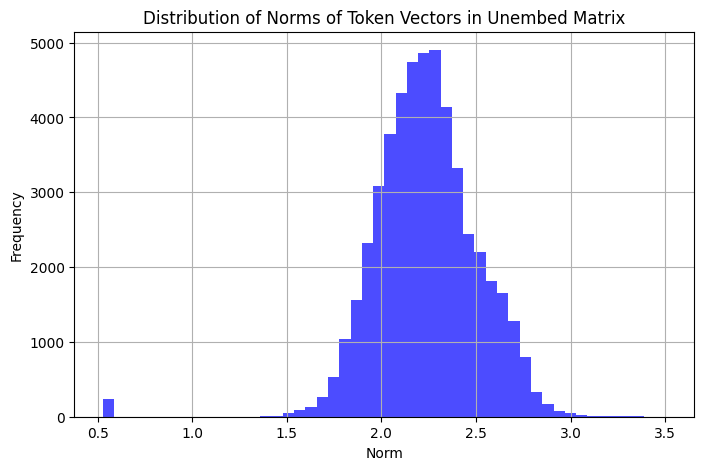

In [15]:
#these are the statistics of unembed vector norms of pythia2.8b
unembed=model.unembed.W_U
norms=torch.norm(unembed, dim=0)
norms_np=norms.detach().cpu().numpy()
# Print summary statistics
print("Norms: mean =", norms_np.mean(), "min =", norms_np.min(), "max =", norms_np.max())

# Plot the histogram
plt.figure(figsize=(8,5))
plt.hist(norms_np, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Norms of Token Vectors in Unembed Matrix')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
#this prints the count of token along with the norm of the corresponding unembed vector in unembedding matrix of pyhthia
decoded_tokens = []
unembed_weights = model.unembed.W_U  # Shape: [vocab_size, embedding_dim]
for token_id, count in least_tokens:
    token_str = tokenizer.decode([token_id])
    token_vector = unembed_weights[:,token_id]  # Extract embedding vector for the token
    norm = torch.norm(token_vector).item()    # Compute the vector norm (L2 by default)
    
    decoded_tokens.append({
        "token_id": token_id,
        "count": count,
        "token_str": token_str,
        "norm": norm
    })

# Display results
for entry in decoded_tokens:
    print(f"ID: {entry['token_id']}, Count: {entry['count']}, Token: '{entry['token_str']}', Norm: {entry['norm']:.4f}")

ID: 20758, Count: 1, Token: 'CLUDING', Norm: 3.3164
ID: 23413, Count: 1, Token: 'chemic', Norm: 2.6152
ID: 20248, Count: 1, Token: ' uncert', Norm: 2.7520
ID: 20885, Count: 1, Token: 'lotte', Norm: 2.9570
ID: 44740, Count: 1, Token: ' /*!<', Norm: 2.5176
ID: 5655, Count: 1, Token: 'bolds', Norm: 2.8691
ID: 32053, Count: 1, Token: '�', Norm: 2.5352
ID: 10794, Count: 1, Token: ' inval', Norm: 2.5605
ID: 44417, Count: 1, Token: ' assort', Norm: 2.4629
ID: 7755, Count: 1, Token: ' colle', Norm: 2.7715
ID: 9641, Count: 1, Token: 'inical', Norm: 2.4062
ID: 40450, Count: 1, Token: 'complet', Norm: 2.6152
ID: 6103, Count: 1, Token: ' strugg', Norm: 2.8809
ID: 45477, Count: 1, Token: 'negie', Norm: 2.7344
ID: 30491, Count: 1, Token: 'OMNI', Norm: 2.6719
ID: 9926, Count: 1, Token: 'perties', Norm: 2.5977
ID: 33379, Count: 1, Token: ' biomed', Norm: 2.4160
ID: 4649, Count: 1, Token: ' algorith', Norm: 2.5410
ID: 12350, Count: 1, Token: ' affili', Norm: 2.6211
ID: 22311, Count: 1, Token: 'เ', Norm

# Covariance of dimensions
* experiment as mentioned in tuned lens paper

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datasets import load_dataset
import torch
from transformer_lens import HookedTransformer
from huggingface_hub import login 
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
hf_token = "<your token>"
login(token=hf_token)

In [19]:
model = HookedTransformer.from_pretrained("google/gemma-2-2b-it", device="cuda", torch_dtype=torch.float16)

model.eval()
for param in model.parameters():
    param.requires_grad = False

tokenizer = model.tokenizer

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


In [21]:
num_samples=45
dataset = load_dataset("allenai/c4", name="en", split="train", streaming=True)
text_samples = []
for example in dataset:
    text = example.get("text", "").strip()
    if text:
        text_samples.append(text)
    if len(text_samples) >= num_samples:
        break
print(f"Loaded {len(text_samples)} clean text samples")

# Join all text into one long sequence of tokens
joined_text = "\n\n".join(text_samples) 
all_token_ids = tokenizer.encode(joined_text, return_tensors='pt')[0]  # shape: (total_tokens,)
print(f"Token sequence length: {len(all_token_ids)} tokens")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Loaded 45 clean text samples
Token sequence length: 17045 tokens


In [22]:
prefix_text = "<start_of_turn>user\n"
suffix_text = "<end_of_turn>"

prefix_tokens = tokenizer.encode(prefix_text, add_special_tokens=False)
suffix_tokens = tokenizer.encode(suffix_text, add_special_tokens=False)


In [23]:
def create_dataset_from_tokens(token_ids, seq_len):
    examples = []
    total_tokens = len(token_ids)
    seq_len=seq_len
    for i in range(0, total_tokens - seq_len, seq_len):
        input_ids = token_ids[i : i + seq_len]
        #wrapped_seq=prefix_tokens+input_ids.tolist()+suffix_tokens
        wrapped_seq=input_ids.tolist()
        wrapped_tensor=torch.tensor(wrapped_seq, dtype=torch.long)
        examples.append(wrapped_tensor)
    input_ids_tensor = torch.stack(examples)
    return input_ids_tensor

In [24]:
seq_len=16
target_num_seq = 48
input_ids = create_dataset_from_tokens(all_token_ids, seq_len=seq_len)
input_ids = input_ids[:target_num_seq]
print(len(input_ids))

48


In [25]:
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
d_vocab = model.cfg.d_vocab

In [26]:
with torch.no_grad():
    _, cache = model.run_with_cache(input_ids)
    # Residual stream after each block: shape (batch, seq_len, d_model, layers+1)
    hidden_states = [cache[f'blocks.{i}.hook_resid_post'].cpu() for i in range(model.cfg.n_layers)]


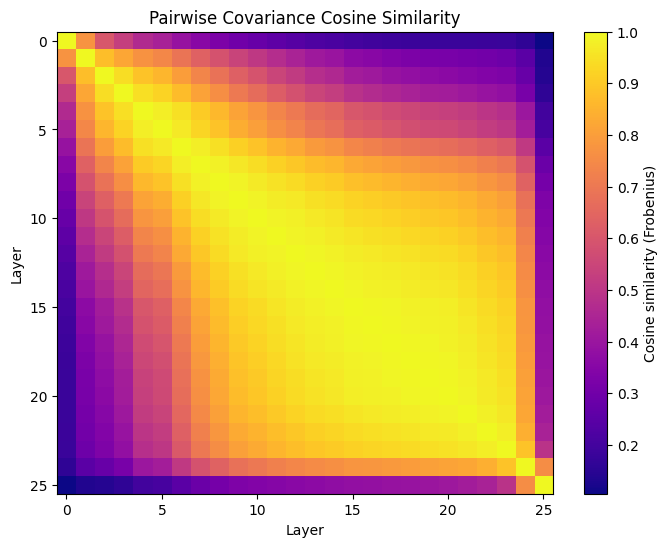

In [27]:
cov_matrices = []
for hs in hidden_states:
    # Flatten across (batch, seq_pos) so hs_flat: [num_sequences * seq_len, d_model]
    hs_flat = hs.view(-1, hs.shape[-1]).numpy()
    cov = np.cov(hs_flat, rowvar=False)
    cov_matrices.append(cov)

n_layers = len(cov_matrices)
similarities = np.zeros((n_layers, n_layers))
for i in range(n_layers):
    for j in range(n_layers):
        sim = np.sum(cov_matrices[i] * cov_matrices[j]) / (
            np.linalg.norm(cov_matrices[i], 'fro') * np.linalg.norm(cov_matrices[j], 'fro')
        )
        similarities[i, j] = sim

plt.figure(figsize=(8, 6))
plt.imshow(similarities, cmap='plasma', aspect='auto')
plt.title("Pairwise Covariance Cosine Similarity")
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.colorbar(label='Cosine similarity (Frobenius)')
plt.show()


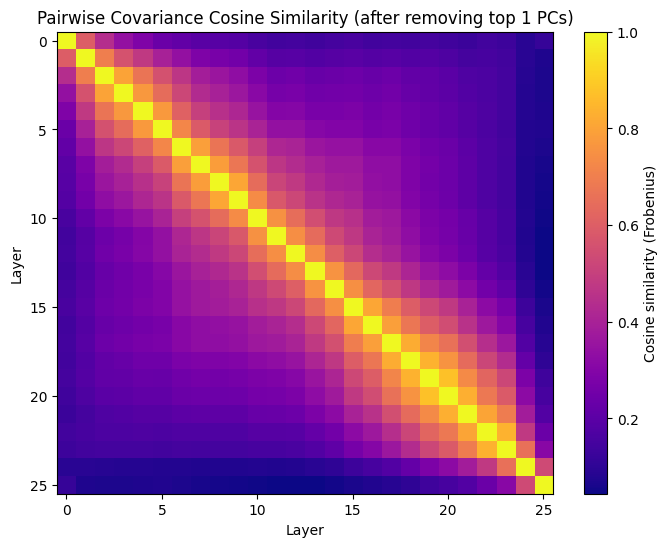

In [28]:
k = 1  # Set this to however many top components you want to remove

cov_matrices = []

for hs in hidden_states:
    # Flatten to shape: (num_samples, d_model)
    hs_flat = hs.view(-1, hs.shape[-1]).numpy()
    # Center the activations (mean 0 for each dim)
    hs_mean = hs_flat.mean(axis=0, keepdims=True)
    hs_centered = hs_flat - hs_mean

    # Fit PCA
    pca = PCA(n_components=hs_flat.shape[0])
    pca.fit(hs_centered)

    # Project onto principal components and remove top k by zeroing them
    pcs = pca.components_[:k]  # shape: (k, d_model)
    projections = hs_centered @ pcs.T  # (num_samples, k)
    # Remove top-k components
    hs_no_topk = hs_centered - (projections @ pcs)
    
    # Compute covariance after top-k removal
    cov = np.cov(hs_no_topk, rowvar=False)
    cov_matrices.append(cov)

n_layers = len(cov_matrices)
similarities = np.zeros((n_layers, n_layers))
for i in range(n_layers):
    for j in range(n_layers):
        sim = np.sum(cov_matrices[i] * cov_matrices[j]) / (
            np.linalg.norm(cov_matrices[i], 'fro') * np.linalg.norm(cov_matrices[j], 'fro')
        )
        similarities[i, j] = sim

plt.figure(figsize=(8, 6))
plt.imshow(similarities, cmap='plasma', aspect='auto')
plt.title(f"Pairwise Covariance Cosine Similarity (after removing top {k} PCs)")
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.colorbar(label='Cosine similarity (Frobenius)')
plt.show()
